## Load and Subset Data

In [565]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Get Data ----------------------------------------------#

# get data from tigress - currently this is Liao's
path = '/home/jennap/projects/LRGROUP/shared_data/Merged_ARGO_WOD_GOSHIP/'
infn = 'Profiles_temp_psal_doxy.nc'

ds = xr.open_dataset(path + infn)
print(ds.keys())

# change time variable ----------------------------------#
# set the units to be something xarray can decode
ds.time.attrs['units'] = 'days since 01-01-1800'
#re-decode the dataset
ds = xr.decode_cf(ds)

KeysView(<xarray.Dataset>
Dimensions:  (pres: 201, prof: 306118)
Coordinates:
  * pres     (pres) int32 0 5 10 15 20 25 30 35 ... 970 975 980 985 990 995 1000
  * prof     (prof) int32 1 2 3 4 5 6 ... 306114 306115 306116 306117 306118
Data variables:
    type     (prof) int32 ...
    lat      (prof) float32 ...
    lon      (prof) float32 ...
    time     (prof) float32 ...
    temp     (prof, pres) float32 ...
    psal     (prof, pres) float32 ...
    doxy     (prof, pres) float32 ...)


In [566]:
# Quality Control ------------------------------------#

upper_temp = ds.temp[:,ds.pres<=450]
upper_doxy = ds.doxy[:,ds.pres<=450]

# set profiles with less than 5 points or if no data above 450dbars to nans
temp_qc = ds.temp
temp_ind = (np.sum(~np.isnan(upper_temp),1) <5)
temp_qc[temp_ind,:] = np.nan

doxy_qc = ds.doxy
doxy_ind = (np.sum(~np.isnan(upper_doxy),1) <5)
doxy_qc[doxy_ind,:] = np.nan

# add in the time, lat and lon values here later


#add to dataset
ds['temp_qc'] = temp_qc
ds['doxy_qc'] = doxy_qc

In [576]:
# Find one-sided dT/dp and dO/dp
temp_grad = temp_qc.diff("pres")/ds.pres.diff("pres")
doxy_grad = doxy_qc.diff("pres")/ds.pres.diff("pres")

# average pressures
pres_grad = (np.array(ds.pres[1:]) + np.array(ds.pres[:-1]))/2

#add to dataset
ds['temp_grad'] = xr.DataArray(temp_grad,dims = ['prof','pres_grad'],coords =[ds.prof,grad_pres])
ds['doxy_grad'] = xr.DataArray(doxy_grad,dims = ['prof','pres_grad'],coords =[ds.prof,grad_pres])

In [577]:
# lightly smooth profiles


In [589]:
#mask the nans in the arrays so that the functions work as expected 
temp_grad = np.ma.masked_array(ds.temp_grad, np.isnan(ds.temp_grad))
doxy_grad = np.ma.masked_array(ds.doxy_grad, np.isnan(ds.doxy_grad))

# find maximum negative gradients (min grad)
temp_grad_min_ind = np.argmin(temp_grad,1)
doxy_grad_min_ind = np.argmin(doxy_grad,1)

# take the pressure value at the min index
TCD = pres_grad[temp_grad_min_ind]
OCD = pres_grad[doxy_grad_min_ind]
TCD

#set places where profiles were all nans to nan
TCD[np.sum(~np.isnan(temp_qc),1) <1] = np.nan
OCD[np.sum(~np.isnan(doxy_qc),1) <1] = np.nan

# set all values that are lower than 450dbar to nan
TCD[TCD > 450] = np.nan
OCD[OCD > 450] = np.nan

#add to dataset
ds['TCD'] = xr.DataArray(TCD,dims = ['prof'],coords =[ds.prof])
ds['OCD'] = xr.DataArray(OCD,dims = ['prof'],coords =[ds.prof])
ds

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


nan

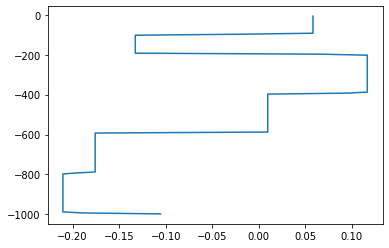

In [579]:
plt.plot(ds.doxy_grad[306113,:],-1*ds.pres_grad)

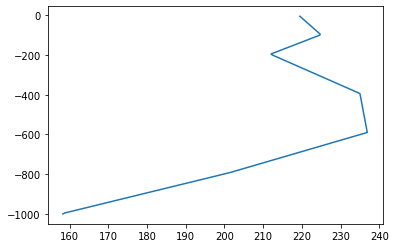

In [580]:
plt.plot(ds.doxy[306113,:],-1*ds.pres)

797.5

In [573]:
a = np.vstack(([np.nan]*10, np.arange(10), np.arange(11, 1, -1)))
m = np.ma.masked_array(a, np.isnan(a))
m

masked_array(
  data=[[--, --, --, --, --, --, --, --, --, --],
        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0],
        [11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0]],
  mask=[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False]],
  fill_value=1e+20)

In [574]:
np.argmin(m, axis=0)

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [575]:
a.shape

(3, 10)